# 4. Data augmentation

> <div class="alert alert-block alert-info">
    <b>Lets now look at a technique called Data augmentation.</b>
<br></br>
<b>Data augmentation allows us to generate new images (artificial data) by slightly modifying the images in the training set by applying different transformations. In this notebook, we will use shifting, rotating and zooming transformations to modify the data and generate new examples.</b>
<br></br>
<b>One of the benefits of data augmentation is it acts as a regularizer and helps to reduce overfitting when training a model. This is because with more artificially generated images, the model is unable to overfit to specific examples and is forced to generalize, thus the model becomes more robust. This generally leads to a better overall performance.</b></div>

In [40]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

### 4.0 Load data

In [2]:
X_train = np.load('./tmp/X_train.npy')
y_train = np.load('./tmp/y_train.npy')
X_val = np.load('./tmp/X_val.npy')
y_val = np.load('./tmp/y_val.npy')
X_test = np.load('./tmp/X_test.npy')

### 4.1 Creating an ImageDataGenerator

In [3]:
from keras.preprocessing.image import ImageDataGenerator

In [4]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        width_shift_range=0.1, 
        height_shift_range=0.1,
        zoom_range = 0.10,  
)

> <div class="alert alert-block alert-info">
<b>ImageDataGenerator is a brilliant class in keras, which allows us to augment images in real-time while our model is training. This means we can pass it as input to the model, and new augmented images will be generated in batches on the go.</b></div>

> <div class="alert alert-block alert-info">
<b>Here is a good explanation about the class in more depth: https://deepchecks.com/question/what-is-the-output-of-imagedatagenerator/</b></div>

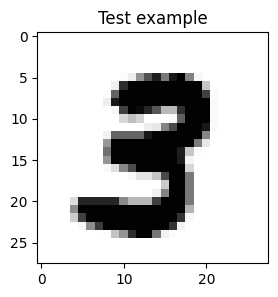

In [5]:
temp_example_X = X_train[1].reshape(-1,28,28,1)
temp_example_y = y_train[1].reshape(-1,10)
plt.figure(figsize=(3,3))
plt.title('Test example')
plt.imshow(temp_example_X.squeeze(), cmap='Greys')

> <div class="alert alert-block alert-info">
<b>Lets select a test example for demonstration, and generate some new images using data augmentation.</b>
</div>

### 4.2 Augmented images visualized

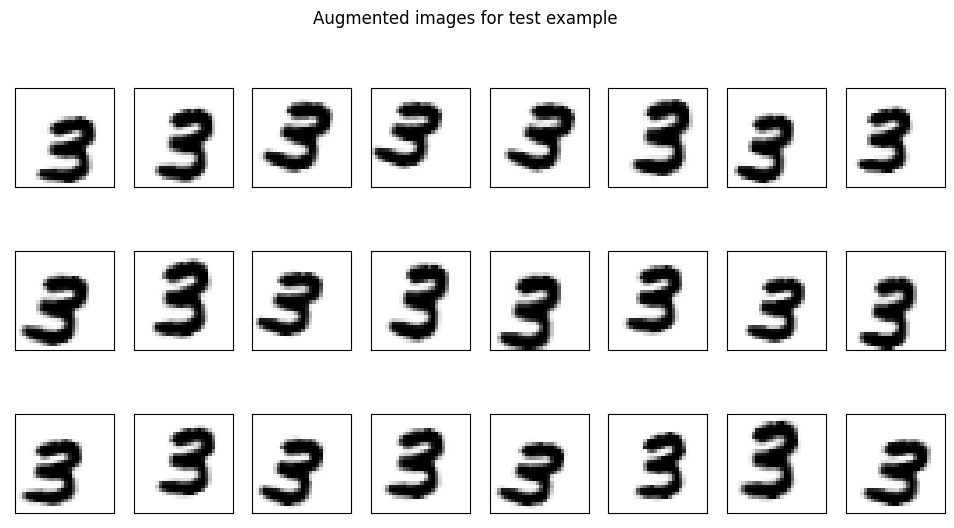

In [6]:

fig, axes = plt.subplots(3,8, figsize=(12,6))
fig.suptitle('Augmented images for test example')
for i in range(3):
    for j in range(8):
        augmented_example_X, augmented_example_y = datagen.flow(temp_example_X, temp_example_y, batch_size=1).next()
        axes[i,j].imshow(augmented_example_X.squeeze(), cmap='Greys')
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

> <div class="alert alert-block alert-info">
<b>Here are the artificial images generated. You can see how much variation can be created by slightly modifying just one image.</b>
</div>

### 4.3 Training network on augmented data

> <div class="alert alert-block alert-info">
<b>Now we should try training the model again, except this time we will train the model using augmented data.</b>
</div>

In [27]:
# Precision (using keras backend)
def precision_metric(y_true, y_pred):
    threshold = 0.5  # Training threshold 0.5
    y_pred_y = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

    true_positives = K.sum(K.clip(y_true * y_pred, 0, 1))
    false_negatives = K.sum(K.clip(y_true * (1-y_pred), 0, 1))
    false_positives = K.sum(K.clip((1-y_true) * y_pred, 0, 1))
    true_negatives = K.sum(K.clip((1 - y_true) * (1-y_pred), 0, 1))

    precision = true_positives / (true_positives + false_positives + K.epsilon())
    return precision

# Recall (using keras backend)
def recall_metric(y_true, y_pred):
    threshold = 0.5 #Training threshold 0.5
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

    true_positives = K.sum(K.clip(y_true * y_pred, 0, 1))
    false_negatives = K.sum(K.clip(y_true * (1-y_pred), 0, 1))
    false_positives = K.sum(K.clip((1-y_true) * y_pred, 0, 1))
    true_negatives = K.sum(K.clip((1 - y_true) * (1-y_pred), 0, 1))

    recall = true_positives / (true_positives + false_negatives + K.epsilon())
    return recall

# F1-score (using keras backend)
def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1 = 2 * ((precision * recall) / (recall+precision+K.epsilon()))
    return f1

def build_model():
    inp = keras.Input(shape=(28,28,1), name="input")
    x = keras.layers.Conv2D(filters=32, kernel_size=(5,5), strides=(1,1),padding='SAME', 
                              activation='relu')(inp)
    x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(5,5), padding='SAME', activation='relu')(x)
    x = keras.layers.MaxPool2D(pool_size=(2,2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    output = keras.layers.Dense(10, activation='softmax')(x)

    model = keras.Model(inputs=inp, outputs=output)

    model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', f1_metric, recall_metric, precision_metric])
    return model, inp, output

from keras import backend as K

batch_size=32

In [28]:
model2, _, _ = build_model()

In [29]:
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

In [30]:
steps_per_epoch = train_generator.n // train_generator.batch_size
steps_per_epoch

1181

In [31]:
print(train_generator.n, train_generator.batch_size)

37800 32


In [32]:
steps_per_epoch

1181

In [33]:
history2 = model2.fit(train_generator, validation_data=(X_val, y_val), epochs=40, steps_per_epoch=steps_per_epoch,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',patience=10, 
                                                            min_delta=0.005, restore_best_weights=True),
                              keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3)])

Epoch 1/40


2023-02-22 13:40:51.818624: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


1181/1181 [==============================] - 18s 9ms/step - loss: 0.7775 - accuracy: 0.7465 - f1_metric: 0.6651 - recall_metric: 0.6745 - precision_metric: 0.6584 - val_loss: 0.0938 - val_accuracy: 0.9733 - val_f1_metric: 0.9573 - val_recall_metric: 0.9676 - val_precision_metric: 0.9473 - lr: 1.0000e-04
Epoch 2/40
1181/1181 [==============================] - 10s 8ms/step - loss: 0.2737 - accuracy: 0.9132 - f1_metric: 0.8819 - recall_metric: 0.8964 - precision_metric: 0.8682 - val_loss: 0.0748 - val_accuracy: 0.9764 - val_f1_metric: 0.9681 - val_recall_metric: 0.9737 - val_precision_metric: 0.9626 - lr: 1.0000e-04
Epoch 3/40
1181/1181 [==============================] - 10s 8ms/step - loss: 0.1960 - accuracy: 0.9392 - f1_metric: 0.9184 - recall_metric: 0.9295 - precision_metric: 0.9077 - val_loss: 0.0541 - val_accuracy: 0.9831 - val_f1_metric: 0.9764 - val_recall_metric: 0.9808 - val_precision_metric: 0.9720 - lr: 1.0000e-04
Epoch 4/40
1181/1181 [==============================] - 10s 8ms

> <div class="alert alert-block alert-info">
    <b>Training the model on augmented data..</b>
</div>

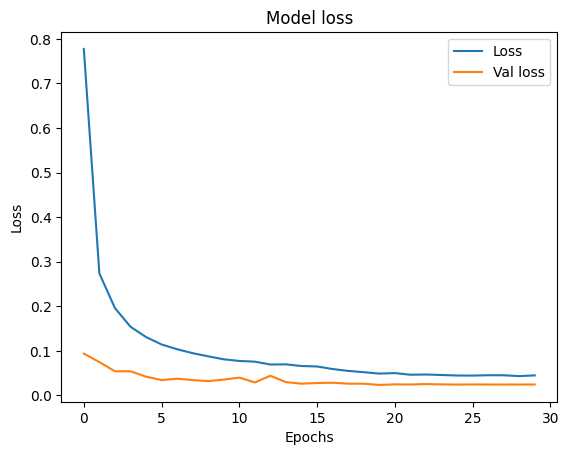

In [34]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss','Val loss'])

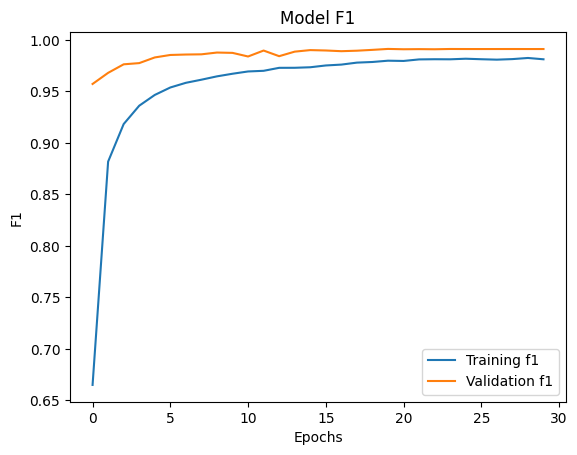

In [35]:
plt.plot(history2.history['f1_metric'])
plt.plot(history2.history['val_f1_metric'])
plt.title('Model F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(['Training f1','Validation f1'])

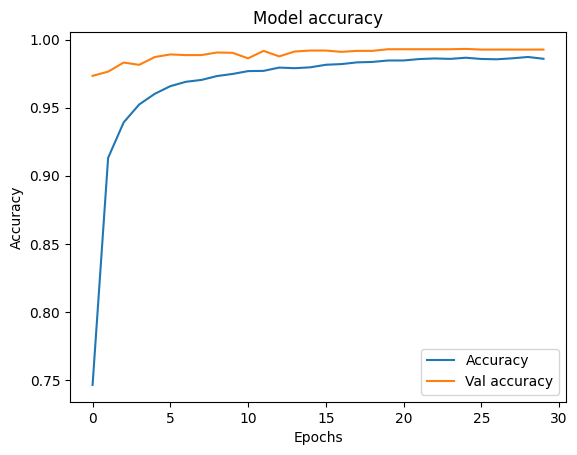

In [36]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy','Val accuracy'])

### 4.4 Validation results on augmented data

In [37]:
y_val_pred = np.argmax(model2.predict(X_val), axis=1)
y_val_pred

array([6, 2, 7, ..., 3, 1, 5])

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_val_true = np.argmax(y_val,axis=1)

Text(50.722222222222214, 0.5, 'True')

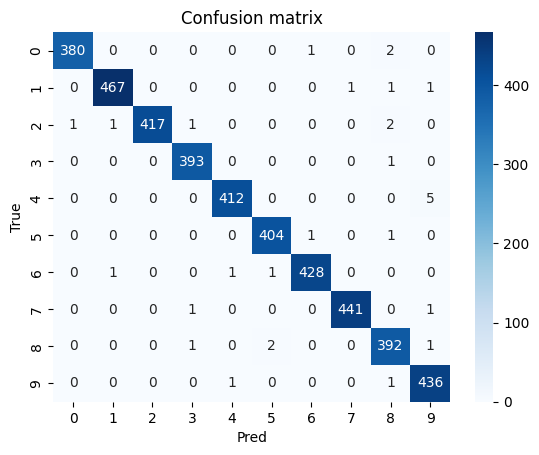

In [43]:
sns.heatmap(confusion_matrix(np.argmax(y_val,axis=1), y_val_pred), annot=True, cmap='Blues', fmt='g')
plt.title('Confusion matrix')
plt.xlabel('Pred')
plt.ylabel('True')

In [48]:
accuracy_score(y_val_true, y_val_pred)

0.9928571428571429

> <div class="alert alert-block alert-info">
<b>We can see using data augmentation has improved our accuracy score by over 0.2%, which is quite a lot considering we are in the top 1% of accuracy score.</b>
</div>

In [49]:
y_test_pred = model2.predict(X_test)
y_test_pred = np.argmax(y_test_pred,axis=1)
test_results = pd.DataFrame({'ImageID': np.arange(1,28001,1), 'Label': y_test_pred})

In [50]:
tf.saved_model.save(model2, "./tmp/saved_augmented_model")

2023-02-22 13:55:51.004067: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./tmp/saved_augmented_model/assets


In [53]:
!python -m tf2onnx.convert --saved-model ./tmp/saved_augmented_model --output ./tmp/model-aug.onnx --opset 13 1> /dev/null

/usr/lib64/python3.8/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-02-22 13:56:54,411 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-02-22 13:56:55,045 - INFO - Signatures found in model: [serving_default].
2023-02-22 13:56:55,045 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-02-22 13:56:55,045 - INFO - Output names: ['dense_7']
2023-02-22 13:56:55,363 - INFO - Using tensorflow=2.7.4, onnx=1.13.0, tf2onnx=1.13.0/2c1db5
2023-02-22 13:56:55,363 - INFO - Using opset <onnx, 13>
2023-02-22 13:56:55,578 - INFO - Computed 0 values for constant folding
2023-02-22 13:56:55,713 - INFO - Optimizing ONNX model
2023-02-22 13:56:55,778 - INFO - After optimization: Cast -1 (1->0), Const +1 (17->18), Identity -2 (2->0), Reshape +1 (1->2), Transpose -11 (12-

In [55]:
import boto3
from boto3 import session
import os

key_id = os.environ.get("AWS_ACCESS_KEY_ID")
secret_key = os.environ.get("AWS_SECRET_ACCESS_KEY")
bucket_name = os.environ.get("AWS_S3_BUCKET")
s3_endpoint = os.environ.get("AWS_S3_ENDPOINT")

s3_client = boto3.client("s3", aws_access_key_id=key_id, aws_secret_access_key=secret_key, endpoint_url=s3_endpoint)

In [56]:
s3_client.upload_file("./tmp/model-aug.onnx", bucket_name, "onnx/model-v2-aug.onnx")